# **AGCN- Install Dependencies**

In [ ]:
# Cell 1: Install Dependencies (A100 optimized)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install tensorboardX tqdm pyyaml einops
!pip install torchinfo

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Setup and Imports**

In [ ]:
# Cell 2: Setup and Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import time
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import os
from torchinfo import summary
from torch.cuda import amp

# Enable TF32 for A100 GPU (3x faster)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")


Using device: cuda


In [ ]:
import numpy as np
import pickle
import os

# Data/label locations (edit for X-View or bone if needed)
train_data = '/content/drive/MyDrive/ntu_normalized/xsub_train_data_joint.npy'
val_data   = '/content/drive/MyDrive/ntu_normalized/xsub_val_data_joint.npy'
train_label = '/content/drive/MyDrive/ntu_processed/xsub/train/train_label.pkl'
val_label   = '/content/drive/MyDrive/ntu_processed/xsub/val/val_label.pkl'

# Check files exist
print("Train data:", os.path.exists(train_data), "| Val data:", os.path.exists(val_data))
print("Train label:", os.path.exists(train_label), "| Val label:", os.path.exists(val_label))

# Print label counts and a sample
with open(train_label, 'rb') as f:
    sample_names, sample_labels = pickle.load(f)
print(f"Train samples: {len(sample_labels)} | Example label: {sample_labels[0]}")
with open(val_label, 'rb') as f:
    val_names, val_labels = pickle.load(f)
print(f"Val samples: {len(val_labels)} | Example label: {val_labels[0]}")

# Print one data sample shape
sample = np.load(train_data, mmap_mode='r')
print("Train data shape (N,C,T,V,M):", sample.shape)
print("One sample min/max:", sample[0].min(), sample[0].max())


Train data: True | Val data: True
Train label: True | Val label: True
Train samples: 33383 | Example label: 16
Val samples: 23327 | Example label: 13
Train data shape (N,C,T,V,M): (33383, 3, 300, 25, 2)
One sample min/max: -1.9420302618199796 0.8381361333212642


In [ ]:
print("Unique classes in train:", len(set(sample_labels)))
print("Unique classes in val:", len(set(val_labels)))


Unique classes in train: 60
Unique classes in val: 60


In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        # For reproducibility, disable CUDNN benchmark and enable deterministic
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(42)


# **Enhanced Feeder Class**

In [ ]:
# Cell 3: Enhanced Feeder Class with Augmentation
class Feeder(Dataset):
    def __init__(self, data_path, label_path, train=False, debug=False, use_mmap=True):
        self.debug = debug
        self.data_path = data_path
        self.label_path = label_path
        self.use_mmap = use_mmap
        self.train = train
        self.load_data()

    def load_data(self):
        with open(self.label_path, 'rb') as f:
            try:
                self.sample_name, self.label = pickle.load(f)
            except:
                self.sample_name, self.label = pickle.load(f, encoding='latin1')
        if self.use_mmap:
            self.data = np.load(self.data_path, mmap_mode='r')
        else:
            self.data = np.load(self.data_path)
        if self.debug:
            self.label = self.label[:100]
            self.data = self.data[:100]
            self.sample_name = self.sample_name[:100]

    def temporal_crop(self, data, crop_length=300):
        """Random temporal cropping with 10% variation"""
        T = data.shape[1]
        if T > crop_length:
            start = np.random.randint(0, T - crop_length)
            return data[:, start:start+crop_length, :, :]
        return data

    def spatial_flip(self, data):
        """Random spatial flip with 50% probability"""
        if np.random.rand() > 0.5:
            data[0] = -data[0]  # Flip x-axis coordinates
        return data

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        data = np.array(self.data[idx])  # Convert mmap to array

        if self.train:
            data = self.temporal_crop(data)
            data = self.spatial_flip(data)

        return data, int(self.label[idx])


# **Official Code AGCN**

In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np

def conv_branch_init(conv, branches):
    weight = conv.weight
    n = weight.size(0)
    k1 = weight.size(1)
    k2 = weight.size(2)
    nn.init.normal_(weight, 0, math.sqrt(2. / (n * k1 * k2 * branches)))
    nn.init.constant_(conv.bias, 0)

def conv_init(conv):
    nn.init.kaiming_normal_(conv.weight, mode='fan_out')
    nn.init.constant_(conv.bias, 0)

def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)

class unit_tcn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9, stride=1):
        super(unit_tcn, self).__init__()
        pad = int((kernel_size - 1) / 2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(pad, 0),
                              stride=(stride, 1))
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        conv_init(self.conv)
        bn_init(self.bn, 1)
    def forward(self, x):
        x = self.bn(self.conv(x))
        return x

class unit_gcn(nn.Module):
    def __init__(self, in_channels, out_channels, A, coff_embedding=4, num_subset=3):
        super(unit_gcn, self).__init__()
        inter_channels = out_channels // coff_embedding
        self.inter_c = inter_channels
        self.PA = nn.Parameter(torch.from_numpy(A.astype(np.float32)))
        nn.init.constant_(self.PA, 1e-6)
        self.A = torch.tensor(A.astype(np.float32), requires_grad=False)
        self.num_subset = num_subset
        self.conv_a = nn.ModuleList()
        self.conv_b = nn.ModuleList()
        self.conv_d = nn.ModuleList()
        for i in range(self.num_subset):
            self.conv_a.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_b.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_d.append(nn.Conv2d(in_channels, out_channels, 1))
        if in_channels != out_channels:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.down = lambda x: x
        self.bn = nn.BatchNorm2d(out_channels)
        self.soft = nn.Softmax(-2)
        self.relu = nn.ReLU(inplace=True)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m, 1)
        bn_init(self.bn, 1e-6)
        for i in range(self.num_subset):
            conv_branch_init(self.conv_d[i], self.num_subset)
    def forward(self, x):
        N, C, T, V = x.size()
        A = self.A.to(x.device) + self.PA
        y = None
        for i in range(self.num_subset):
            A1 = self.conv_a[i](x).permute(0, 3, 1, 2).contiguous().view(N, V, self.inter_c * T)
            A2 = self.conv_b[i](x).view(N, self.inter_c * T, V)
            # Stable softmax to prevent NaN
            temp = torch.matmul(A1, A2) / (A1.size(-1) + 1e-8)
            temp = torch.clamp(temp, -50, 50)
            A1 = self.soft(temp)
            A1 = A1 + A[i]
            A2 = x.view(N, C * T, V)
            z = self.conv_d[i](torch.matmul(A2, A1).view(N, C, T, V))
            y = z + y if y is not None else z
        y = self.bn(y)
        y += self.down(x)
        return self.relu(y)

class TCN_GCN_unit(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, residual=True):
        super(TCN_GCN_unit, self).__init__()
        self.gcn1 = unit_gcn(in_channels, out_channels, A)
        self.tcn1 = unit_tcn(out_channels, out_channels, stride=stride)
        self.relu = nn.ReLU(inplace=True)
        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x
        else:
            self.residual = unit_tcn(in_channels, out_channels, kernel_size=1, stride=stride)
    def forward(self, x):
        x = self.tcn1(self.gcn1(x)) + self.residual(x)
        return self.relu(x)

class Model(nn.Module):
    def __init__(self, num_class=60, num_point=25, num_person=2, graph=None, graph_args=dict(), in_channels=3):
        super(Model, self).__init__()
        class Graph:
            def __init__(self, labeling_mode='spatial'):
                self.num_node = 25
                self.self_link = [(i, i) for i in range(self.num_node)]
                inward_ori_index = [
                    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5), (7, 6),
                    (8, 7), (9, 21), (10, 9), (11, 10), (12, 11), (13, 1),
                    (14, 13), (15, 14), (16, 15), (17, 1), (18, 17), (19, 18),
                    (20, 19), (22, 23), (23, 8), (24, 25), (25, 12)
                ]
                inward = [(i - 1, j - 1) for (i, j) in inward_ori_index]
                outward = [(j, i) for (i, j) in inward]
                neighbor = inward + outward
                def edge2mat(link, num_node):
                    A = np.zeros((num_node, num_node))
                    for i, j in link:
                        A[j, i] = 1
                    return A
                def normalize_digraph(A):
                    Dl = np.sum(A, 0)
                    h, w = A.shape
                    Dn = np.zeros((w, w))
                    for i in range(w):
                        if Dl[i] > 0:
                            Dn[i, i] = Dl[i] ** (-1)
                    AD = np.dot(A, Dn)
                    return AD
                def get_spatial_graph(num_node, self_link, inward, outward):
                    I = edge2mat(self_link, num_node)
                    In = normalize_digraph(edge2mat(inward, num_node))
                    Out = normalize_digraph(edge2mat(outward, num_node))
                    A = np.stack((I, In, Out))
                    return A
                self.A = get_spatial_graph(self.num_node, self.self_link, inward, outward)
        GraphObj = Graph(**graph_args)
        A = GraphObj.A
        self.data_bn = nn.BatchNorm1d(num_person * in_channels * num_point)
        self.l1 = TCN_GCN_unit(3, 64, A, residual=False)
        self.l2 = TCN_GCN_unit(64, 64, A)
        self.l3 = TCN_GCN_unit(64, 64, A)
        self.l4 = TCN_GCN_unit(64, 64, A)
        self.l5 = TCN_GCN_unit(64, 128, A, stride=2)
        self.l6 = TCN_GCN_unit(128, 128, A)
        self.l7 = TCN_GCN_unit(128, 128, A)
        self.l8 = TCN_GCN_unit(128, 256, A, stride=2)
        self.l9 = TCN_GCN_unit(256, 256, A)
        self.l10 = TCN_GCN_unit(256, 256, A)
        self.fc = nn.Linear(256, num_class)
        nn.init.normal_(self.fc.weight, 0, math.sqrt(2. / num_class))
        bn_init(self.data_bn, 1)
    def forward(self, x):
        N, C, T, V, M = x.size()
        x = x.permute(0, 4, 3, 1, 2).contiguous().view(N, M * V * C, T)
        x = self.data_bn(x)
        x = x.view(N, M, V, C, T).permute(0, 1, 3, 4, 2).contiguous().view(N * M, C, T, V)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        x = self.l6(x)
        x = self.l7(x)
        x = self.l8(x)
        x = self.l9(x)
        x = self.l10(x)
        c_new = x.size(1)
        x = x.view(N, M, c_new, -1)
        x = x.mean(3).mean(1)
        return self.fc(x)


# **Model Summary**

In [ ]:
from torchinfo import summary
import torch

BATCH_SIZE = 48  # You can set this to 64, 72, or whatever your training uses
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dummy input for NTU RGB+D skeleton: (batch, C, T, V, M)
dummy_input_size = (BATCH_SIZE, 3, 300, 25, 2)

# Import your Model class as AGCN if needed (alias)
# from your_model_file import Model as AGCN

model = Model(num_class=60, num_point=25, num_person=2).to(DEVICE)

# It's good practice to always move model to correct device *before* summary
summary(model, input_size=dummy_input_size, device=DEVICE.type)


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [48, 60]                  --
├─BatchNorm1d: 1-1                       [48, 150, 300]            300
├─TCN_GCN_unit: 1-2                      [96, 64, 300, 25]         --
│    └─unit_gcn: 2-1                     [96, 64, 300, 25]         1,875
│    │    └─ModuleList: 3-9              --                        (recursive)
│    │    └─ModuleList: 3-10             --                        (recursive)
│    │    └─Softmax: 3-3                 [96, 25, 25]              --
│    │    └─ModuleList: 3-12             --                        (recursive)
│    │    └─ModuleList: 3-9              --                        (recursive)
│    │    └─ModuleList: 3-10             --                        (recursive)
│    │    └─Softmax: 3-7                 [96, 25, 25]              --
│    │    └─ModuleList: 3-12             --                        (recursive)
│    │    └─ModuleList: 3-9

# **Training Loop**

In [ ]:
def train_and_evaluate_agcn(
    train_data_path, train_label_path,
    val_data_path, val_label_path,
    save_path, batch_size=48, epochs=80, patience=15, plot_prefix=None
):
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create datasets with augmentation for training
    train_set = Feeder(train_data_path, train_label_path, train=True)
    val_set = Feeder(val_data_path, val_label_path)

    # Custom collate function
    def custom_collate(batch):
        data = [item[0] for item in batch]
        labels = [item[1] for item in batch]
        data = torch.stack([torch.from_numpy(np.copy(d)).float() for d in data], 0)
        labels = torch.LongTensor(labels)
        return data, labels

    # Create dataloaders
    train_loader = DataLoader(train_set, batch_size=batch_size,
                             shuffle=True, num_workers=4,
                             pin_memory=True, collate_fn=custom_collate)
    val_loader = DataLoader(val_set, batch_size=batch_size,
                           shuffle=False, num_workers=2,
                           collate_fn=custom_collate)

    # Initialize model
    model = Model(num_class=60, num_point=25, num_person=2).to(DEVICE)

    # Optimizer and scheduler
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,
                         nesterov=True, weight_decay=0.0005)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[35, 45, 55], gamma=0.2)
    criterion = nn.CrossEntropyLoss()

    # Mixed precision scaler - UPDATED SYNTAX
    scaler = torch.cuda.amp.GradScaler()  # No arguments needed

    best_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss, total, correct = 0.0, 0, 0

        # Training loop with mixed precision - UPDATED SYNTAX
        for data, label in train_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            optimizer.zero_grad()

            # UPDATED AUTOCAST SYNTAX
            with torch.cuda.amp.autocast():
                outputs = model(data)
                loss = criterion(outputs, label)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * data.size(0)
            _, predicted = outputs.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_total, val_correct = 0.0, 0, 0
        with torch.no_grad():
            for data, label in val_loader:
                data, label = data.to(DEVICE), label.to(DEVICE)
                outputs = model(data)
                loss = criterion(outputs, label)
                val_loss += loss.item() * data.size(0)
                _, predicted = outputs.max(1)
                val_total += label.size(0)
                val_correct += predicted.eq(label).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total
        epoch_time = time.time() - start_time

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Update scheduler
        scheduler.step()

        print(f"Epoch {epoch+1:2d}/{epochs} | Time: {epoch_time:.1f}s | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch+1
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print(f"  New best model saved! (Acc: {best_acc:.4f})")

            # Early exit if target achieved
            if best_acc >= 0.912:  # 91.2% accuracy target
                print("  Target accuracy reached! Stopping early.")
                break
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    print(f"Best Validation Accuracy: {best_acc:.4f} at Epoch {best_epoch}")

    # Plotting
    if plot_prefix:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.legend()
        plt.title('Loss Curve')

        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Acc')
        plt.plot(history['val_acc'], label='Val Acc')
        plt.axhline(y=0.912, color='r', linestyle='--', label='Target')
        plt.legend()
        plt.title('Accuracy Curve')

        plt.tight_layout()
        plt.savefig(f"{plot_prefix}_training_curve.png")
        plt.show()

    return best_acc, best_epoch, history

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# **X-VIEW Result AGCN**

Starting enhanced AGCN training with batch size 48...
Epoch  1/70 | Time: 262.7s | Train Loss: 3.0128 Acc: 0.1688 | Val Loss: 2.4345 Acc: 0.2844
  New best model saved! (Acc: 0.2844)
Epoch  2/70 | Time: 262.5s | Train Loss: 1.9942 Acc: 0.4009 | Val Loss: 1.8867 Acc: 0.4327
  New best model saved! (Acc: 0.4327)
Epoch  3/70 | Time: 261.4s | Train Loss: 1.5458 Acc: 0.5364 | Val Loss: 1.4504 Acc: 0.5600
  New best model saved! (Acc: 0.5600)
Epoch  4/70 | Time: 261.6s | Train Loss: 1.2934 Acc: 0.6125 | Val Loss: 1.3157 Acc: 0.6103
  New best model saved! (Acc: 0.6103)
Epoch  5/70 | Time: 261.9s | Train Loss: 1.1352 Acc: 0.6559 | Val Loss: 1.7537 Acc: 0.5254
Epoch  6/70 | Time: 261.2s | Train Loss: 1.0434 Acc: 0.6858 | Val Loss: 1.7434 Acc: 0.5296
Epoch  7/70 | Time: 261.3s | Train Loss: 0.9928 Acc: 0.6990 | Val Loss: 0.9610 Acc: 0.7124
  New best model saved! (Acc: 0.7124)
Epoch  8/70 | Time: 261.6s | Train Loss: 0.9300 Acc: 0.7174 | Val Loss: 1.3166 Acc: 0.6259
Epoch  9/70 | Time: 261.9s |

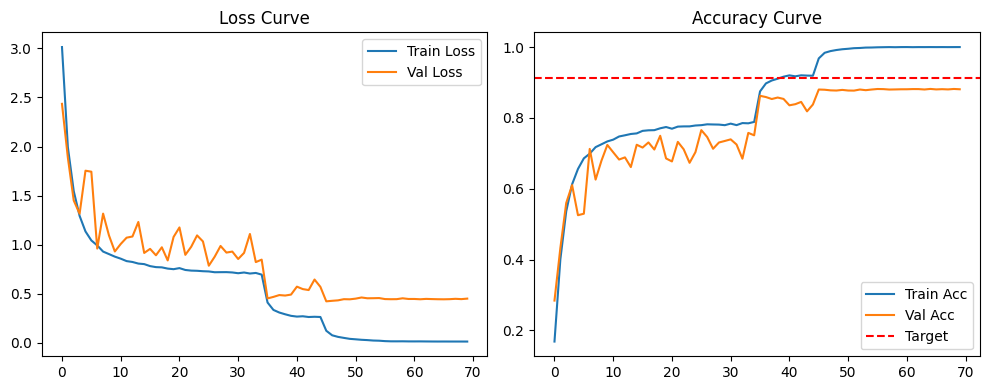


Final Best Validation Accuracy: 0.8817 at Epoch 65


In [ ]:
# Cell 6: Path Configuration (Update with your paths)
Xview_train_data = '/content/drive/MyDrive/ntu_normalized/xview_train_data_joint.npy'
Xview_train_label = '/content/drive/MyDrive/ntu_processed/xview/train/train_label.pkl'
Xview_val_data = '/content/drive/MyDrive/ntu_normalized/xview_val_data_joint.npy'
Xview_val_label = '/content/drive/MyDrive/ntu_processed/xview/val/val_label.pkl'

# Cell 7: Run Enhanced Training
print("Starting enhanced AGCN training with batch size 48...")
best_acc, best_epoch, history = train_and_evaluate_agcn(
    Xview_train_data, Xview_train_label,
    Xview_val_data, Xview_val_label,
    save_path='/content/improv_best_agcn_xview_enhanced.pth',
    batch_size=48,
    epochs=70,
    patience=15,
    plot_prefix='AGCN_XView'
)

print(f"\nFinal Best Validation Accuracy: {best_acc:.4f} at Epoch {best_epoch}")


# **X-SUB AGCN**

Starting enhanced AGCN training with batch size 48...
Epoch  1/80 | Time: 250.0s | Train Loss: 3.2006 Acc: 0.1426 | Val Loss: 2.6304 Acc: 0.2313
  New best model saved! (Acc: 0.2313)
Epoch  2/80 | Time: 249.8s | Train Loss: 2.1829 Acc: 0.3418 | Val Loss: 2.0735 Acc: 0.3820
  New best model saved! (Acc: 0.3820)
Epoch  3/80 | Time: 249.5s | Train Loss: 1.7875 Acc: 0.4543 | Val Loss: 1.8614 Acc: 0.4542
  New best model saved! (Acc: 0.4542)
Epoch  4/80 | Time: 248.9s | Train Loss: 1.5183 Acc: 0.5408 | Val Loss: 1.4886 Acc: 0.5469
  New best model saved! (Acc: 0.5469)
Epoch  5/80 | Time: 249.5s | Train Loss: 1.3321 Acc: 0.5964 | Val Loss: 1.9022 Acc: 0.4992
Epoch  6/80 | Time: 249.2s | Train Loss: 1.2031 Acc: 0.6336 | Val Loss: 1.2736 Acc: 0.6258
  New best model saved! (Acc: 0.6258)
Epoch  7/80 | Time: 249.9s | Train Loss: 1.1020 Acc: 0.6644 | Val Loss: 1.3003 Acc: 0.6120
Epoch  8/80 | Time: 249.7s | Train Loss: 1.0277 Acc: 0.6916 | Val Loss: 1.7424 Acc: 0.5425
Epoch  9/80 | Time: 249.3s |

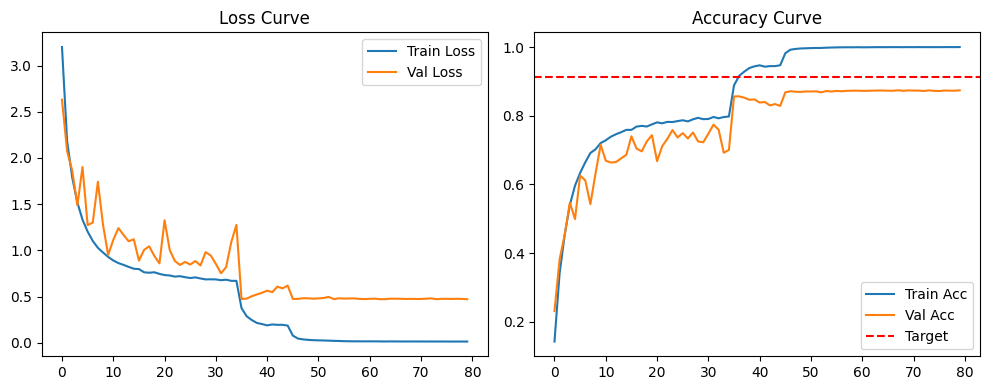


Final Best Validation Accuracy: 0.8741 at Epoch 68


In [ ]:
# Cell 6: Path Configuration (Update with your paths)
Xsub_train_data = '/content/drive/MyDrive/ntu_normalized/xsub_train_data_joint.npy'
Xsub_train_label = '/content/drive/MyDrive/ntu_processed/xsub/train/train_label.pkl'
Xsub_val_data = '/content/drive/MyDrive/ntu_normalized/xsub_val_data_joint.npy'
Xsub_val_label = '/content/drive/MyDrive/ntu_processed/xsub/val/val_label.pkl'

# Cell 7: Run Enhanced Training
print("Starting enhanced AGCN training with batch size 48...")
best_acc, best_epoch, history = train_and_evaluate_agcn(
    Xsub_train_data, Xsub_train_label,
    Xsub_val_data, Xsub_val_label,
    save_path='/content/improv_best_agcn_xsub_enhanced.pth',
    batch_size=48,
    epochs=80,
    patience=15,
    plot_prefix='AGCN_XSUB'
)

print(f"\nFinal Best Validation Accuracy: {best_acc:.4f} at Epoch {best_epoch}")


# **ShiftGCN- Insatall Dependencies**

In [ ]:
# Install required packages
!pip install einops tensorboardX seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.7 MB/s eta 0:00:00


# **Install Depenndencies**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
import time
import random


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)


Device: cuda


## **Normlization**

In [ ]:
def normalize(data):
    mean = data.mean(axis=(1,2,3), keepdims=True)
    std = data.std(axis=(1,2,3), keepdims=True) + 1e-8
    return (data - mean) / std

def random_temporal_crop(data, crop_len=300):
    T = data.shape[1]
    if T > crop_len:
        start = np.random.randint(0, T-crop_len)
        return data[:, start:start+crop_len, :, :]
    elif T < crop_len:
        out = np.zeros((data.shape[0], crop_len, data.shape[2], data.shape[3]), dtype=data.dtype)
        out[:, :T, :, :] = data
        return out
    else:
        return data

def random_flip(data, p=0.5):
    if random.random() < p:
        data = data.copy()
        data[0, :, :, :] *= -1  # flip X axis
    return data

def augment(data):
    data = random_temporal_crop(data)
    data = random_flip(data)
    return data

In [ ]:
bone_pairs_ntu = [
    (1, 0), (2, 1), (3, 2), (4, 3), (5, 1), (6, 5), (7, 6), (8, 7),
    (9, 1), (10, 9), (11, 10), (12, 11), (13, 0), (14, 13), (15, 14), (16, 15),
    (17, 0), (18, 17), (19, 18), (20, 19), (21, 0), (22, 21), (23, 22), (24, 2)
]

class NTUDatasetNpy(Dataset):
    def __init__(self, X_path, y_path, bone_pairs=None, train=True, do_norm=True, do_aug=True):
        self.X = np.load(X_path)
        self.y = np.load(y_path)
        self.train = train
        self.do_norm = do_norm
        self.do_aug = do_aug
        self.bone_pairs = bone_pairs
    def __len__(self):
        return len(self.y)
    def compute_bone(self, joint_data):
        bone_data = np.zeros_like(joint_data)
        if self.bone_pairs:
            for v1, v2 in self.bone_pairs:
                bone_data[:, :, v1, :] = joint_data[:, :, v1, :] - joint_data[:, :, v2, :]
        return bone_data
    def __getitem__(self, idx):
        d = self.X[idx].astype(np.float32)  # (300, 25, 3)
        d = np.transpose(d, (2, 0, 1))[..., np.newaxis]  # (3, 300, 25, 1)
        if self.train and self.do_aug:
            d = augment(d)
        if self.do_norm:
            d = normalize(d)
        bone = self.compute_bone(d)
        label = int(self.y[idx])
        return torch.from_numpy(d), torch.from_numpy(bone), label

# **ShiftGCN Code**

In [ ]:
class ShiftGraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, A):
        super().__init__()
        self.num_subset = 3
        self.A = nn.Parameter(A.clone(), requires_grad=False)
        self.conv = nn.ModuleList([nn.Conv2d(in_channels, out_channels, 1) for _ in range(self.num_subset)])
        if in_channels != out_channels:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.down = nn.Identity()
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        N, C, T, V = x.size()
        y = None
        for i in range(self.num_subset):
            z = torch.einsum('nctv,vw->nctw', (x, self.A[i]))
            z = self.conv[i](z)
            y = z if y is None else y + z
        y = self.bn(y)
        y = y + self.down(x)
        return self.relu(y)

class ShiftGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, residual=True):
        super().__init__()
        self.gcn = ShiftGraphConv(in_channels, out_channels, A)
        self.tcn = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, (9,1), stride=(stride,1), padding=(4,0)),
            nn.BatchNorm2d(out_channels)
        )
        if not residual:
            self.residual = lambda x: 0
        elif in_channels == out_channels and stride == 1:
            self.residual = nn.Identity()
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=(stride,1)),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        y = self.gcn(x)
        y = self.tcn(y)
        res = self.residual(x)
        return self.relu(y + res)

class ShiftGCN(nn.Module):
    def __init__(self, num_classes=60, num_point=25):
        super().__init__()
        A = self.build_adjacency(num_point)
        in_channels = 3
        self.layers = nn.ModuleList([
            ShiftGCNBlock(in_channels, 64, A, stride=1, residual=False),
            ShiftGCNBlock(64, 64, A, stride=1),
            ShiftGCNBlock(64, 64, A, stride=1),
            ShiftGCNBlock(64, 64, A, stride=1),
            ShiftGCNBlock(64, 128, A, stride=2),
            ShiftGCNBlock(128, 128, A, stride=1),
            ShiftGCNBlock(128, 128, A, stride=1),
            ShiftGCNBlock(128, 256, A, stride=2),
            ShiftGCNBlock(256, 256, A, stride=1),
            ShiftGCNBlock(256, 256, A, stride=1)
        ])
        self.fc = nn.Linear(256, num_classes)
    def build_adjacency(self, num_point):
        self_link = [(i, i) for i in range(num_point)]
        inward = [(1,2),(2,21),(3,21),(4,3),(5,21),(6,5),(7,6),(8,7),(9,21),(10,9),(11,10),(12,11),(13,1),(14,13),(15,14),(16,15),(17,1),(18,17),(19,18),(20,19),(22,23),(23,8),(24,25),(25,12)]
        inward = [(i-1, j-1) for (i,j) in inward]
        outward = [(j, i) for (i, j) in inward]
        A = torch.zeros(3, num_point, num_point)
        for i, j in self_link:
            A[0, i, j] = 1
        for i, j in inward:
            A[1, i, j] = 1
        for i, j in outward:
            A[2, i, j] = 1
        return A
    def forward(self, x):
        # x: (N, C, T, V, M)
        N, C, T, V, M = x.size()
        x = x.permute(0, 4, 1, 2, 3).contiguous().view(N*M, C, T, V)
        for layer in self.layers:
            x = layer(x)
        x = x.mean(dim=3)  # spatial
        x = x.mean(dim=2)  # temporal
        x = x.view(N, M, -1).mean(dim=1)
        return self.fc(x)

class TwoStreamShiftGCN(nn.Module):
    def __init__(self, num_classes=60):
        super().__init__()
        self.joint_stream = ShiftGCN(num_classes)
        self.bone_stream = ShiftGCN(num_classes)
    def forward(self, joint, bone):
        joint_logits = self.joint_stream(joint)
        bone_logits = self.bone_stream(bone)
        return (joint_logits + bone_logits) / 2

# **Training Loop**

In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for joint, bone, label in loader:
        joint = joint.cuda()
        bone = bone.cuda()
        label = label.cuda()
        optimizer.zero_grad()
        out = model(joint, bone)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * label.size(0)
        _, pred = out.max(1)
        correct += pred.eq(label).sum().item()
        total += label.size(0)
    return total_loss/total, correct/total

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for joint, bone, label in loader:
            joint = joint.cuda()
            bone = bone.cuda()
            label = label.cuda()
            out = model(joint, bone)
            loss = criterion(out, label)
            total_loss += loss.item() * label.size(0)
            _, pred = out.max(1)
            correct += pred.eq(label).sum().item()
            total += label.size(0)
    return total_loss/total, correct/total

def run_training(X_train, y_train, X_val, y_val, model_save, max_epochs=80, patience=20):
    train_ds = NTUDatasetNpy(X_train, y_train, bone_pairs_ntu, train=True, do_norm=True, do_aug=True)
    val_ds = NTUDatasetNpy(X_val, y_val, bone_pairs_ntu, train=False, do_norm=True, do_aug=False)
    train_loader = DataLoader(train_ds, batch_size=48, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=48, shuffle=False, num_workers=4, pin_memory=True)
    model = TwoStreamShiftGCN(num_classes=60).cuda()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0
    patience_counter = 0
    hist = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    for epoch in range(1, max_epochs+1):
        t0 = time.time()
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        scheduler.step()
        hist['train_loss'].append(train_loss)
        hist['train_acc'].append(train_acc)
        hist['val_loss'].append(val_loss)
        hist['val_acc'].append(val_acc)
        print(f"Epoch {epoch}: Train loss={train_loss:.4f}, acc={train_acc:.3f} | Val loss={val_loss:.4f}, acc={val_acc:.3f} | time={time.time()-t0:.1f}s")
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), model_save)
            print("  Best model saved!")
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    print(f"Best validation accuracy: {best_acc*100:.2f}%")
    # Plotting
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(hist['train_loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.legend(); plt.title('Loss'); plt.grid()
    plt.subplot(1,2,2)
    plt.plot(hist['train_acc'], label='Train Acc')
    plt.plot(hist['val_acc'], label='Val Acc')
    plt.legend(); plt.title('Accuracy'); plt.grid()
    plt.show()
    return best_acc, hist

In [ ]:
# X-Sub paths (update to your own Google Drive location)
X_train_cs = '/content/drive/MyDrive/ntu_dataset/X_train_cs.npy'
y_train_cs = '/content/drive/MyDrive/ntu_dataset/y_train_cs.npy'
X_val_cs   = '/content/drive/MyDrive/ntu_dataset/X_val_cs.npy'
y_val_cs   = '/content/drive/MyDrive/ntu_dataset/y_val_cs.npy'

# X-View paths (update to your own Google Drive location)
X_train_cv = '/content/drive/MyDrive/ntu_dataset/X_train_cv.npy'
y_train_cv = '/content/drive/MyDrive/ntu_dataset/y_train_cv.npy'
X_val_cv   = '/content/drive/MyDrive/ntu_dataset/X_val_cv.npy'
y_val_cv   = '/content/drive/MyDrive/ntu_dataset/y_val_cv.npy'


In [ ]:
import numpy as np

# Example paths (replace with your own if different)
X_train_cs = '/content/drive/MyDrive/ntu_dataset/X_train_cs.npy'
y_train_cs = '/content/drive/MyDrive/ntu_dataset/y_train_cs.npy'

# Load the data
data = np.load(X_train_cs)
labels = np.load(y_train_cs)

print('X_train_cs shape:', data.shape)
print('y_train_cs shape:', labels.shape)


X_train_cs shape: (26706, 300, 25, 3)
y_train_cs shape: (26706,)


# **ShiftGCN- Training Result**


====== X-Sub Training ======
Epoch 1: Train loss=2.7205, acc=0.228 | Val loss=2.4067, acc=0.314 | time=165.6s
  Best model saved!
Epoch 2: Train loss=1.9879, acc=0.410 | Val loss=1.9811, acc=0.407 | time=164.1s
  Best model saved!
Epoch 3: Train loss=1.6863, acc=0.492 | Val loss=1.6910, acc=0.498 | time=164.1s
  Best model saved!
Epoch 4: Train loss=1.4665, acc=0.557 | Val loss=1.7804, acc=0.464 | time=164.1s
Epoch 5: Train loss=1.3162, acc=0.602 | Val loss=1.4340, acc=0.567 | time=164.1s
  Best model saved!
Epoch 6: Train loss=1.1964, acc=0.637 | Val loss=1.3160, acc=0.603 | time=164.1s
  Best model saved!
Epoch 7: Train loss=1.0989, acc=0.663 | Val loss=1.2286, acc=0.625 | time=164.1s
  Best model saved!
Epoch 8: Train loss=1.0283, acc=0.682 | Val loss=1.2887, acc=0.608 | time=164.1s
Epoch 9: Train loss=0.9653, acc=0.701 | Val loss=1.1348, acc=0.646 | time=164.1s
  Best model saved!
Epoch 10: Train loss=0.9124, acc=0.719 | Val loss=1.0878, acc=0.665 | time=164.1s
  Best model saved!

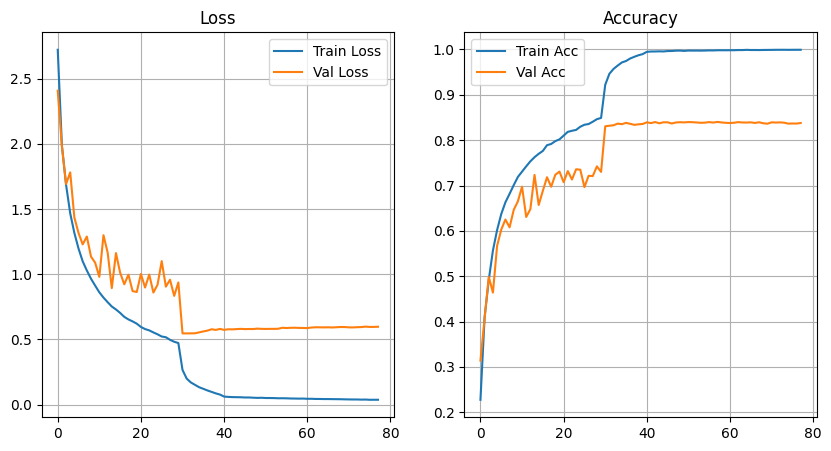

[X-Sub] Best Val Acc: 0.8402


====== X-View Training ======
Epoch 1: Train loss=2.7094, acc=0.224 | Val loss=2.5187, acc=0.273 | time=185.8s
  Best model saved!
Epoch 2: Train loss=1.9323, acc=0.425 | Val loss=1.9053, acc=0.432 | time=185.8s
  Best model saved!
Epoch 3: Train loss=1.5815, acc=0.528 | Val loss=1.5627, acc=0.531 | time=185.8s
  Best model saved!
Epoch 4: Train loss=1.3600, acc=0.592 | Val loss=2.0724, acc=0.445 | time=185.8s
Epoch 5: Train loss=1.2193, acc=0.626 | Val loss=1.5486, acc=0.554 | time=185.8s
  Best model saved!
Epoch 6: Train loss=1.1056, acc=0.661 | Val loss=1.2261, acc=0.627 | time=185.8s
  Best model saved!
Epoch 7: Train loss=1.0195, acc=0.683 | Val loss=1.3552, acc=0.596 | time=185.8s
Epoch 8: Train loss=0.9594, acc=0.703 | Val loss=1.2588, acc=0.619 | time=185.8s
Epoch 9: Train loss=0.9063, acc=0.718 | Val loss=1.1005, acc=0.656 | time=185.8s
  Best model saved!
Epoch 10: Train loss=0.8495, acc=0.733 | Val loss=1.0523, acc=0.668 | time=185.8s
  Best m

In [ ]:
# --- 5. Train! ---

print("\n====== X-Sub Training ======")
acc_xsub, hist_xsub = run_training(
    X_train_cs, y_train_cs, X_val_cs, y_val_cs,
    model_save='/content/improved_48_best_shiftgcn_xsub.pth', max_epochs=80, patience=20
)
print(f"[X-Sub] Best Val Acc: {acc_xsub:.4f}\n{'='*60}\n")



====== X-View Training ======
Epoch 1: Train loss=2.7223, acc=0.226 | Val loss=2.5732, acc=0.280 | time=187.1s
  Best model saved!
Epoch 2: Train loss=1.9420, acc=0.420 | Val loss=1.8680, acc=0.442 | time=185.8s
  Best model saved!
Epoch 3: Train loss=1.6196, acc=0.511 | Val loss=1.9870, acc=0.436 | time=185.7s
Epoch 4: Train loss=1.4065, acc=0.573 | Val loss=2.5202, acc=0.390 | time=185.7s
Epoch 5: Train loss=1.2657, acc=0.615 | Val loss=1.4554, acc=0.567 | time=185.7s
  Best model saved!
Epoch 6: Train loss=1.1662, acc=0.644 | Val loss=1.1989, acc=0.630 | time=185.7s
  Best model saved!
Epoch 7: Train loss=1.0751, acc=0.667 | Val loss=1.3209, acc=0.610 | time=185.8s
Epoch 8: Train loss=1.0033, acc=0.690 | Val loss=1.0975, acc=0.661 | time=185.8s
  Best model saved!
Epoch 9: Train loss=0.9450, acc=0.707 | Val loss=1.2554, acc=0.627 | time=185.8s
Epoch 10: Train loss=0.8945, acc=0.721 | Val loss=1.0560, acc=0.685 | time=185.7s
  Best model saved!
Epoch 11: Train loss=0.8483, acc=0.735

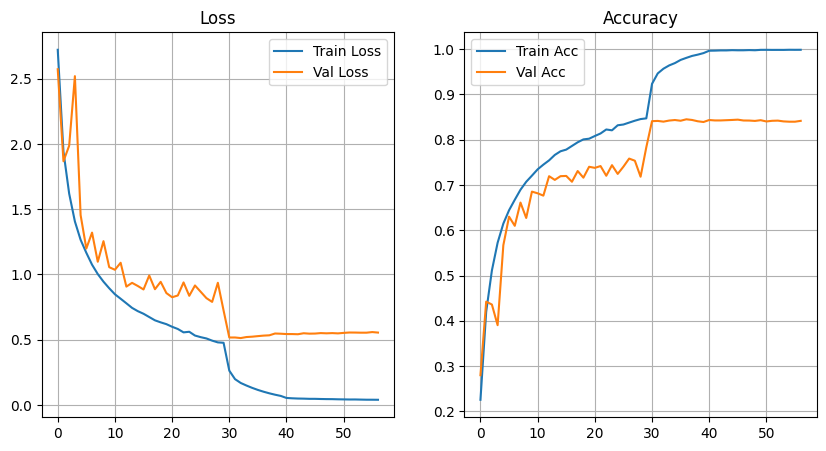

[X-View] Best Val Acc: 0.8452



In [ ]:
print("\n====== X-View Training ======")
acc_xview, hist_xview = run_training(
    X_train_cv, y_train_cv, X_val_cv, y_val_cv,
    model_save='/content/improved_48_best_shiftgcn_xview.pth', max_epochs=80, patience=20
)
print(f"[X-View] Best Val Acc: {acc_xview:.4f}\n{'='*60}\n")

# **3- CTRGCN**

In [ ]:
!pip install torch torchvision torchaudio
!pip install einops lion-pytorch
!pip install tensorboardX tqdm pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvj

In [ ]:
import torch
import numpy as np
import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)


In [ ]:
import torch.nn as nn
import math

# ---- Graph Class
class NTUGraph:
    def __init__(self, labeling_mode='spatial'):
        self.num_node = 25
        self.self_link = [(i, i) for i in range(self.num_node)]
        inward_ori_index = [
            (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5), (7, 6),
            (8, 7), (9, 21), (10, 9), (11, 10), (12, 11), (13, 1),
            (14, 13), (15, 14), (16, 15), (17, 1), (18, 17), (19, 18),
            (20, 19), (22, 23), (23, 8), (24, 25), (25, 12)
        ]
        inward = [(i - 1, j - 1) for (i, j) in inward_ori_index]
        outward = [(j, i) for (i, j) in inward]
        neighbor = inward + outward
        def edge2mat(link, num_node):
            A = np.zeros((num_node, num_node))
            for i, j in link:
                A[j, i] = 1
            return A
        def normalize_digraph(A):
            Dl = np.sum(A, 0)
            h, w = A.shape
            Dn = np.zeros((w, w))
            for i in range(w):
                if Dl[i] > 0:
                    Dn[i, i] = Dl[i] ** (-1)
            AD = np.dot(A, Dn)
            return AD
        def get_spatial_graph(num_node, self_link, inward, outward):
            I = edge2mat(self_link, num_node)
            In = normalize_digraph(edge2mat(inward, num_node))
            Out = normalize_digraph(edge2mat(outward, num_node))
            A = np.stack((I, In, Out))
            return A
        self.A = get_spatial_graph(self.num_node, self.self_link, inward, outward)

# ---- Model Blocks
def conv_branch_init(conv, branches):
    weight = conv.weight
    n, k1, k2 = weight.size(0), weight.size(1), weight.size(2)
    nn.init.normal_(weight, 0, math.sqrt(2. / (n * k1 * k2 * branches)))
    if conv.bias is not None:
        nn.init.constant_(conv.bias, 0)
def conv_init(conv):
    if conv.weight is not None:
        nn.init.kaiming_normal_(conv.weight, mode='fan_out')
    if conv.bias is not None:
        nn.init.constant_(conv.bias, 0)
def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)

class unit_gcn(nn.Module):
    def __init__(self, in_channels, out_channels, A, coff_embedding=4, adaptive=True, residual=True):
        super(unit_gcn, self).__init__()
        inter_channels = out_channels // coff_embedding
        self.inter_c = inter_channels
        self.out_c = out_channels
        self.in_c = in_channels
        self.adaptive = adaptive
        self.num_subset = A.shape[0]
        self.convs = nn.ModuleList()
        for i in range(self.num_subset):
            self.convs.append(nn.Conv2d(in_channels, out_channels, 1))
        if in_channels != out_channels:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.down = lambda x: x
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        if self.adaptive:
            self.PA = nn.Parameter(torch.from_numpy(A.astype(np.float32)))
        else:
            self.A = torch.tensor(A.astype(np.float32), requires_grad=False)
        bn_init(self.bn, 1e-6)
        for i in range(self.num_subset):
            conv_branch_init(self.convs[i], self.num_subset)
    def forward(self, x):
        N, C, T, V = x.size()
        if self.adaptive:
            A = self.PA
        else:
            A = self.A.to(x.device)
        y = None
        for i in range(self.num_subset):
            A1 = A[i]
            z = self.convs[i](torch.einsum('nctv,vw->nctw', (x, A1)))
            y = z + y if y is not None else z
        y = self.bn(y)
        y += self.down(x)
        return self.relu(y)

class unit_tcn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9, stride=1):
        super(unit_tcn, self).__init__()
        pad = int((kernel_size - 1) / 2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(pad, 0),
                              stride=(stride, 1))
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        conv_init(self.conv)
        bn_init(self.bn, 1)
    def forward(self, x):
        x = self.bn(self.conv(x))
        return x

class TCN_GCN_unit(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, residual=True, adaptive=True):
        super(TCN_GCN_unit, self).__init__()
        self.gcn1 = unit_gcn(in_channels, out_channels, A, adaptive=adaptive)
        self.tcn1 = unit_tcn(out_channels, out_channels, stride=stride)
        self.relu = nn.ReLU(inplace=True)
        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x
        else:
            self.residual = unit_tcn(in_channels, out_channels, kernel_size=1, stride=stride)
    def forward(self, x):
        y = self.tcn1(self.gcn1(x)) + self.residual(x)
        return self.relu(y)

class CTRGCN_Model(nn.Module):
    def __init__(self, num_class=60, num_point=25, num_person=2, in_channels=3, adaptive=True):
        super(CTRGCN_Model, self).__init__()
        self.graph = NTUGraph()
        A = self.graph.A
        self.data_bn = nn.BatchNorm1d(num_person * in_channels * num_point)
        self.l1 = TCN_GCN_unit(3, 64, A, residual=False, adaptive=adaptive)
        self.l2 = TCN_GCN_unit(64, 64, A, adaptive=adaptive)
        self.l3 = TCN_GCN_unit(64, 64, A, adaptive=adaptive)
        self.l4 = TCN_GCN_unit(64, 64, A, adaptive=adaptive)
        self.l5 = TCN_GCN_unit(64, 128, A, stride=2, adaptive=adaptive)
        self.l6 = TCN_GCN_unit(128, 128, A, adaptive=adaptive)
        self.l7 = TCN_GCN_unit(128, 128, A, adaptive=adaptive)
        self.l8 = TCN_GCN_unit(128, 256, A, stride=2, adaptive=adaptive)
        self.l9 = TCN_GCN_unit(256, 256, A, adaptive=adaptive)
        self.l10 = TCN_GCN_unit(256, 256, A, adaptive=adaptive)
        self.fc = nn.Linear(256, num_class)
        nn.init.normal_(self.fc.weight, 0, math.sqrt(2. / num_class))
        bn_init(self.data_bn, 1)
    def forward(self, x):
        N, C, T, V, M = x.size()
        x = x.permute(0, 4, 3, 1, 2).contiguous().view(N, M * V * C, T)
        x = self.data_bn(x)
        x = x.view(N, M, V, C, T).permute(0, 1, 3, 4, 2).contiguous().view(N * M, C, T, V)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        x = self.l6(x)
        x = self.l7(x)
        x = self.l8(x)
        x = self.l9(x)
        x = self.l10(x)
        c_new = x.size(1)
        x = x.view(N, M, c_new, -1)
        x = x.mean(3).mean(1)
        return self.fc(x)

import pickle
from torch.utils.data import Dataset

class Feeder(Dataset):
    def __init__(self, data_path, label_path, debug=False):
        self.debug = debug
        self.data_path = data_path
        self.label_path = label_path
        self.load_data()
    def load_data(self):
        with open(self.label_path, 'rb') as f:
            self.sample_name, self.label = pickle.load(f)
        self.data = np.load(self.data_path, mmap_mode='r')
        if self.debug:
            self.label = self.label[0:100]
            self.data = self.data[0:100]
            self.sample_name = self.sample_name[0:100]
    def __len__(self):
        return len(self.label)
    def __getitem__(self, index):
        data_numpy = self.data[index]
        label = self.label[index]
        return data_numpy, label

def custom_collate(batch):
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    data = torch.stack([torch.from_numpy(np.copy(d)).float() for d in data], 0)
    labels = torch.LongTensor(labels)
    return data, labels


In [ ]:
from torch.utils.data import DataLoader
from lion_pytorch import Lion
import time
import matplotlib.pyplot as plt
import torch

# Optional: for rare CUDA stability issues (especially in Colab)
torch.backends.cudnn.benchmark = False

def train_and_evaluate_ctrgcn(
    train_data_path, train_label_path,
    val_data_path, val_label_path,
    save_path, batch_size=48, epochs=55, patience=7, plot_prefix=None
):
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_set = Feeder(train_data_path, train_label_path)
    val_set = Feeder(val_data_path, val_label_path)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True, collate_fn=custom_collate, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=custom_collate, pin_memory=True)
    model = CTRGCN_Model(num_class=60, num_point=25, num_person=2).to(DEVICE)
    optimizer = Lion(model.parameters(), lr=0.0005)  # Lower learning rate for Lion
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()

    best_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'epoch_time': []}

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss, total, correct = 0.0, 0, 0
        for data, label in train_loader:
            data, label = data.to(DEVICE).float(), label.to(DEVICE)
            # NaN/Inf checks
            if torch.isnan(data).any() or torch.isinf(data).any():
                print('Data batch contains NaN/Inf!')
            if torch.isnan(label).any() or torch.isinf(label).any():
                print('Label batch contains NaN/Inf!')
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)
            _, predicted = outputs.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()
        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_total, val_correct = 0.0, 0, 0
        with torch.no_grad():
            for data, label in val_loader:
                data, label = data.to(DEVICE).float(), label.to(DEVICE)
                if torch.isnan(data).any() or torch.isinf(data).any():
                    print('Val data batch contains NaN/Inf!')
                if torch.isnan(label).any() or torch.isinf(label).any():
                    print('Val label batch contains NaN/Inf!')
                outputs = model(data)
                loss = criterion(outputs, label)
                val_loss += loss.item() * data.size(0)
                _, predicted = outputs.max(1)
                val_total += label.size(0)
                val_correct += predicted.eq(label).sum().item()
        val_loss /= val_total
        val_acc = val_correct / val_total
        epoch_time = time.time() - start_time

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch_time'].append(epoch_time)

        print(f"Epoch {epoch+1:2d}/{epochs} | Time: {epoch_time:.2f}s | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch+1
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        scheduler.step()

    print(f"Best Validation Accuracy: {best_acc:.4f} at Epoch {best_epoch}")
    if plot_prefix:
        plt.figure(figsize=(8,4))
        plt.plot(history['train_acc'], label='Train Acc')
        plt.plot(history['val_acc'], label='Val Acc')
        plt.title(f'Accuracy: {plot_prefix}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        plt.show()
    return best_acc, best_epoch, history, model, val_loader


Training on X-Sub (batch=48, fast)...
Epoch  1/80 | Time: 242.86s | Train Loss: 2.9623 Acc: 0.1897 | Val Loss: 2.3126 Acc: 0.3266
Epoch  2/80 | Time: 243.12s | Train Loss: 1.9249 Acc: 0.4296 | Val Loss: 1.5496 Acc: 0.5403
Epoch  3/80 | Time: 242.52s | Train Loss: 1.4243 Acc: 0.5719 | Val Loss: 1.2514 Acc: 0.6302
Epoch  4/80 | Time: 242.26s | Train Loss: 1.1561 Acc: 0.6497 | Val Loss: 1.0542 Acc: 0.6833
Epoch  5/80 | Time: 242.23s | Train Loss: 1.0007 Acc: 0.6959 | Val Loss: 0.9104 Acc: 0.7212
Epoch  6/80 | Time: 242.40s | Train Loss: 0.8724 Acc: 0.7326 | Val Loss: 0.8628 Acc: 0.7392
Epoch  7/80 | Time: 242.25s | Train Loss: 0.7756 Acc: 0.7625 | Val Loss: 0.8003 Acc: 0.7613
Epoch  8/80 | Time: 242.34s | Train Loss: 0.6945 Acc: 0.7823 | Val Loss: 0.7690 Acc: 0.7720
Epoch  9/80 | Time: 242.34s | Train Loss: 0.6266 Acc: 0.8055 | Val Loss: 0.7492 Acc: 0.7763
Epoch 10/80 | Time: 242.35s | Train Loss: 0.5670 Acc: 0.8213 | Val Loss: 0.7185 Acc: 0.7898
Epoch 11/80 | Time: 242.62s | Train Loss: 

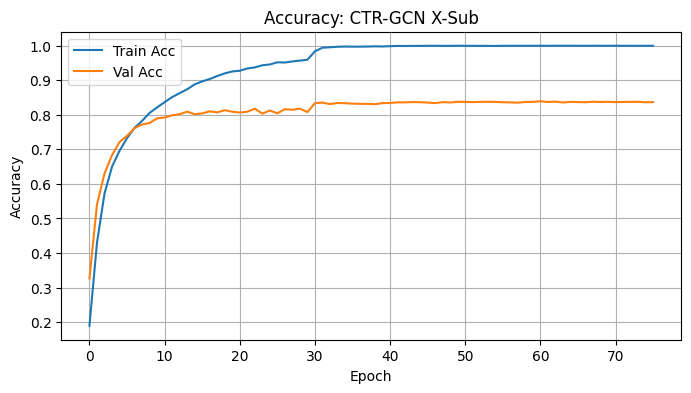


[X-Sub] Best Val Acc: 0.8392 at Epoch 61

Training on X-View (batch=48, fast)...
Epoch  1/80 | Time: 789.84s | Train Loss: 2.7348 Acc: 0.2391 | Val Loss: 1.8833 Acc: 0.4359
Epoch  2/80 | Time: 259.58s | Train Loss: 1.5746 Acc: 0.5260 | Val Loss: 1.2233 Acc: 0.6358
Epoch  3/80 | Time: 259.56s | Train Loss: 1.1575 Acc: 0.6523 | Val Loss: 1.0188 Acc: 0.6965
Epoch  4/80 | Time: 259.43s | Train Loss: 0.9375 Acc: 0.7157 | Val Loss: 0.8778 Acc: 0.7341
Epoch  5/80 | Time: 259.52s | Train Loss: 0.7995 Acc: 0.7563 | Val Loss: 0.7676 Acc: 0.7712
Epoch  6/80 | Time: 259.57s | Train Loss: 0.6938 Acc: 0.7879 | Val Loss: 0.7435 Acc: 0.7785
Epoch  7/80 | Time: 259.54s | Train Loss: 0.6120 Acc: 0.8094 | Val Loss: 0.7112 Acc: 0.7924
Epoch  8/80 | Time: 259.51s | Train Loss: 0.5469 Acc: 0.8280 | Val Loss: 0.6745 Acc: 0.7996
Epoch  9/80 | Time: 259.38s | Train Loss: 0.4871 Acc: 0.8469 | Val Loss: 0.6206 Acc: 0.8179
Epoch 10/80 | Time: 259.40s | Train Loss: 0.4383 Acc: 0.8605 | Val Loss: 0.6414 Acc: 0.812

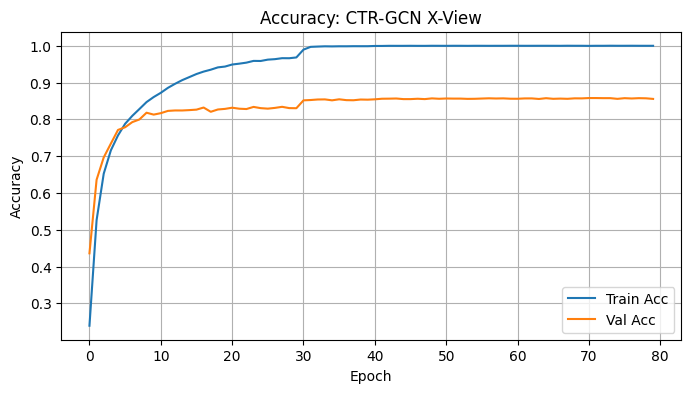


[X-View] Best Val Acc: 0.8578 at Epoch 71



In [ ]:
# X-Sub
Xsub_train_data  = '/content/drive/MyDrive/ntu_normalized/xsub_train_data_joint.npy'
Xsub_train_label = '/content/drive/MyDrive/ntu_processed/xsub/train/train_label.pkl'
Xsub_val_data    = '/content/drive/MyDrive/ntu_normalized/xsub_val_data_joint.npy'
Xsub_val_label   = '/content/drive/MyDrive/ntu_processed/xsub/val/val_label.pkl'

print("Training on X-Sub (batch=48, fast)...")
xsub_best_acc, xsub_best_epoch, xsub_history, xsub_model, xsub_val_loader = train_and_evaluate_ctrgcn(
    Xsub_train_data, Xsub_train_label, Xsub_val_data, Xsub_val_label,
    save_path='/content/best_ctrgcn_xsub.pth', batch_size=48, epochs=80, patience=15, plot_prefix='CTR-GCN X-Sub'
)
print(f"\n[X-Sub] Best Val Acc: {xsub_best_acc:.4f} at Epoch {xsub_best_epoch}\n{'='*60}\n")

# X-View
Xview_train_data  = '/content/drive/MyDrive/ntu_normalized/xview_train_data_joint.npy'
Xview_train_label = '/content/drive/MyDrive/ntu_processed/xview/train/train_label.pkl'
Xview_val_data    = '/content/drive/MyDrive/ntu_normalized/xview_val_data_joint.npy'
Xview_val_label   = '/content/drive/MyDrive/ntu_processed/xview/val/val_label.pkl'

print("Training on X-View (batch=48, fast)...")
xview_best_acc, xview_best_epoch, xview_history, xview_model, xview_val_loader = train_and_evaluate_ctrgcn(
    Xview_train_data, Xview_train_label, Xview_val_data, Xview_val_label,
    save_path='/content/best_ctrgcn_xview.pth', batch_size=48, epochs=80, patience=15, plot_prefix='CTR-GCN X-View'
)
print(f"\n[X-View] Best Val Acc: {xview_best_acc:.4f} at Epoch {xview_best_epoch}\n{'='*60}\n")


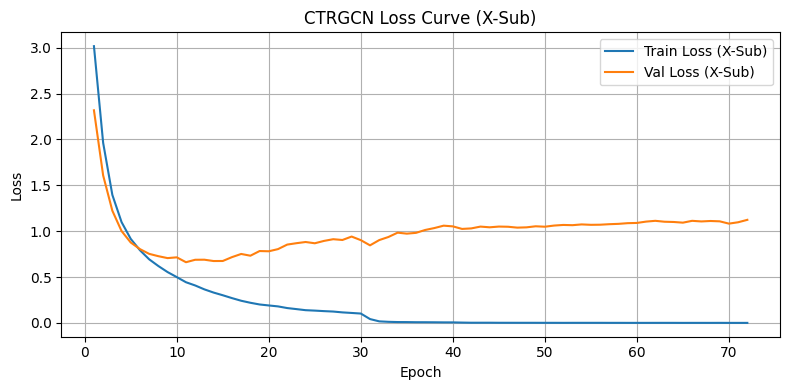

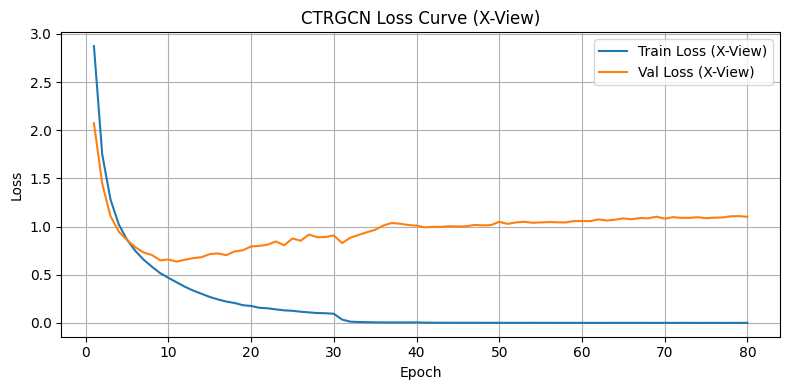

In [ ]:
import matplotlib.pyplot as plt

# Your lists:
# xsub_train_loss = [...]
# xsub_val_loss = [...]
# xview_train_loss = [...]
# xview_val_loss = [...]

# Ensure lengths match epoch counts
epochs_xsub = 72
epochs_xview = 80

# Pad with last value if needed
for l in [xsub_train_loss, xsub_val_loss]:
    while len(l) < epochs_xsub:
        l.append(l[-1])
    while len(l) > epochs_xsub:
        l.pop()
for l in [xview_train_loss, xview_val_loss]:
    while len(l) < epochs_xview:
        l.append(l[-1])
    while len(l) > epochs_xview:
        l.pop()

# Plot X-Sub
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs_xsub+1), xsub_train_loss, label='Train Loss (X-Sub)')
plt.plot(range(1, epochs_xsub+1), xsub_val_loss, label='Val Loss (X-Sub)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CTRGCN Loss Curve (X-Sub)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot X-View
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs_xview+1), xview_train_loss, label='Train Loss (X-View)')
plt.plot(range(1, epochs_xview+1), xview_val_loss, label='Val Loss (X-View)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CTRGCN Loss Curve (X-View)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
